# Example of simulation-based model inference (SBMI)
Simultaneous identification of models and parameters of scientific simulators. 
Schöder and Macke. ICML 2024.
https://arxiv.org/abs/2305.15174

In this notebook we focus on the model inference part. Therefore we only sample from a simple model prior, the graph implementation for the model prior is presented in a later notebook.

We will need GrassmannDistribution, clone it and install it from here:
https://github.com/mackelab/grassmann_binary_distribution/tree/main


### Define model and prior

Similar to the paper we will use an "additive" model: we want to learn a one dimensional function $f(t)$ which can consist of different components, namely:
- linear component: $\theta_1^{1} t$
- linear component:  $\theta_1^{2} t$
- quadratic component: $\theta_1^3 t^2$
- sinusoidal component: $\theta_1^4 \sin(\theta_2^4 t)$
- noise component: $n_{t_i} \sim \mathcal{N}(0, \theta_1^5)$

This results in five model components with in total six parameters, and a partition of the parameter space in $[1,1,1,2,1]$.

The presence/absence of the model components are indicated by a binary vector $M$. 

For simplicity we assume a flat model prior over the component one to three and we assume that the noise term is always present. 

We further assume uniform priors for all parameters $\theta_i^j$. 

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from sbi.utils import get_parameter_mask
from sbi.neural_nets import CNNEmbeddingMasked

from grassmann_distribution.conditional_grassmann import (
    GrassmannConditional,
    hidden_fc_net,
)
from sbi.neural_nets import posterior_nn

from sbi.inference import NPE_SBMI

from sbi.neural_nets.density_estimators.categorical_net_SBMI import CategoricalNet

import matplotlib.pyplot as plt


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [16]:
n_components = 4

partition = torch.tensor([1, 1, 2, 1])  # partition of the parameters

n_params = partition.sum()

prior_bounds = torch.ones((2, partition.sum()))
prior_bounds[0] = 0.5
prior_bounds[1] = 2
# adapt priors for sine
prior_bounds[0, 2] = 3
prior_bounds[1, 2] = 10
prior_bounds[0, 3] = 1.0
prior_bounds[1, 3] = 5.0


def sample_model_components(n, n_components):
    # the last component is always 1
    m = torch.bernoulli(torch.ones((n, n_components)) * 0.5)
    m[:, -1] = 1
    return m.int()


def sample_parameters(m, prior_bounds, partition):
    n, n_components = m.shape
    thetas = torch.rand((n, prior_bounds.shape[1]))
    # scale the thetas to the prior bounds
    thetas = thetas * torch.abs(prior_bounds[1] - prior_bounds[0]) + prior_bounds[0]
    # mask the parameters that are not used
    mask = ~get_parameter_mask(m, partition)
    thetas[mask] = torch.nan
    return thetas


def run_model(m, thetas):
    n, n_components = m.shape

    thetas = thetas.clone()
    thetas[torch.isnan(thetas)] = 0

    t = torch.arange(0, 10, 0.01)

    # additive model components
    l1 = thetas[:, 0].unsqueeze(1) * t
    # l2 = thetas[:, 1].unsqueeze(1) * t
    q = thetas[:, 1].unsqueeze(1) * t**2
    sin = thetas[:, 2].unsqueeze(1) * torch.sin(thetas[:, 3].unsqueeze(1) * t)

    # noise component
    noise = torch.randn(n, len(t)) * thetas[:, 4].unsqueeze(1)

    out = l1 + q + sin + noise  # + l2
    return out


# Lets generate some data

t = torch.arange(0, 10, 0.01)

n_train = 5000

m = sample_model_components(n_train, n_components=n_components)
theta = sample_parameters(m, prior_bounds, partition)
x_raw = run_model(m, theta)

m_test = sample_model_components(100, n_components=n_components)
theta_test = sample_parameters(m_test, prior_bounds, partition)
x_raw_test = run_model(m_test, theta_test)

# and bring it to the correct shape for SBMI
x = torch.cat([x_raw, m], dim=1)
x_test = torch.cat([x_raw_test, m_test], dim=1)

We have created the training data $\{M, \theta, x_{raw}\}$ which we will use for training. 
- $M$ has shape (n_samples, n_components)
- $\theta$ has shape (n_samples, sum(partition))
- $x_{raw}$ has shape (n, number of timepoints)

The SBMI method assumes for training that the model vector is appended to $x_{raw}$:
$x = [x_{raw},m]$

So we are left with the training data $\{\theta, M \}$

Let's have a look at the data:

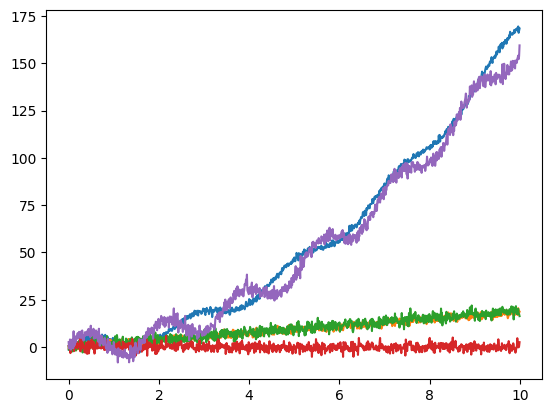

 thetas: tensor([[   nan, 1.6843, 4.3809, 2.8076, 0.9849],
        [1.8150,    nan,    nan,    nan, 0.9973],
        [1.9119,    nan,    nan,    nan, 1.6260],
        [   nan,    nan,    nan,    nan, 1.6886],
        [   nan, 1.6082, 6.9243, 3.6756, 1.9345]])


In [17]:
plt.plot(t, x[:5, :-n_components].T)
plt.show()

print(f" thetas:", theta[:5])

In [18]:
# quick check for the parameters
for i in range(partition.sum()):
    print("min, max, mean of parameter", i, ":")
    print(
        theta[~torch.isnan(theta[:, i]), i].min(),
        theta[~torch.isnan(theta[:, i]), i].max(),
        torch.nanmean(theta[:, i]),
    )

min, max, mean of parameter 0 :
tensor(0.5014) tensor(1.9993) tensor(1.2433)
min, max, mean of parameter 1 :
tensor(0.5005) tensor(1.9996) tensor(1.2461)
min, max, mean of parameter 2 :
tensor(3.0009) tensor(9.9929) tensor(6.4635)
min, max, mean of parameter 3 :
tensor(1.0029) tensor(4.9995) tensor(3.0371)
min, max, mean of parameter 4 :
tensor(0.5001) tensor(1.9998) tensor(1.2417)


### Embedding net


For this time series example we will use a CNN as embedding net. 
As we only want to embed $x_raw$ ($x$ without the model vector) we will use an embedding net which leaves the last dimensions unchanged. 
This is implemented for a CNN, a fully connected net, and obviously `nn.Identity()` can be used if no emedding net is wanted. 

In [19]:
x_dim = x.shape[1]
embedding_dim = 50

embedding_net = CNNEmbeddingMasked(
    input_dim=x_dim + n_components,
    output_dim=embedding_dim,  # this is the effective output dimension, but the last n_components dimensions code the model components
    unchanged_dim=n_components,
    num_fc=3,
    num_hiddens=3,
)

### The model posterior network (MPN)


We can choose between two different model posterior networks: a grassmann network or a categorical network. 

In [20]:
model_posterior_type = "grassmann"  # "categorical"
# Warning:
# GrassmannConditional is returning probs
# CategoricalNet is returning logprobs

if model_posterior_type == "grassmann":
    model_net_prob = "log_prob"
    h = hidden_fc_net(
        input_dim=embedding_dim - n_components,
        output_dim=20,
        num_fc_layers=3,
        num_hiddens=50,  # number of layers
    )  # hidden dimension (should be large enough...)

    model_net = GrassmannConditional(
        features=n_components,  # dim
        hidden_features=20,  # output dim of hidden net
        hidden_net=h,
        num_components=3,  # number of components for the MoGrassmann
    )

elif model_posterior_type == "categorical":
    model_net_prob = "prob"
    model_net = CategoricalNet(
        num_input=embedding_dim - n_components,
        num_categories=2**n_components,
        num_hidden=50,
        num_layers=3,
        binary_vector_input=True,
    )

In [21]:
# test the untrained model
x_emb = embedding_net(x[:10])
probs = model_net(x_emb[:, -n_components:], x_emb[:, :-n_components])
print(probs)

tensor([0.0403, 0.0438, 0.0437, 0.0426, 0.0402, 0.0387, 0.0451, 0.0386, 0.0330,
        0.0437], grad_fn=<SumBackward1>)


### The parameter posterior network
As we SBMI is based on marginalization during training time, we use a Gaussian MDN network with all the necessary functionality. 

In [22]:
density_estimator_build_fun = posterior_nn(
    model="mdn_flex",
    partition=partition,
    hidden_features=50,
    num_components=3,
    z_score_x=None,  # None
    z_score_theta=None,  #'independent'
    embedding_net=embedding_net,
)

With this setup we can use the `SBI` framework: 

In [23]:
inference = NPE_SBMI(
    model_net=model_net,
    partition=partition,
    density_estimator=density_estimator_build_fun,
    loss_kwargs={"model_net": model_net_prob},
)

### Training

In [24]:
# append the simulations to the inference object
inference = inference.append_simulations(theta, x)

# set seed
torch.manual_seed(2023)

# train the inference model
density_estimator = inference.train(
    max_num_epochs=1000,
    training_batch_size=1000,
    learning_rate=5e-3,
    force_first_round_loss=True,
    model_loss_weight=1,
    validation_fraction=0.1,  # fraction of data used for validation. Default=0.1
    stop_after_epochs=25,  # number of epochs to wait before training is stopped. Default=20
)

 Training neural network. Epochs trained: 12

In [27]:
sbi_posterior = inference.build_posterior()
dict_to_save = {
    "summary": inference.summary,
    "sbi_posterior": sbi_posterior,
    "model_net": inference._model_net,
}

# with open("inference.pkl", "wb") as f:
#     pickle.dump(dict_to_save, f)
# print("model saved.")

AssertionError: Original and re-transformed parameters must be close to each other.